# Presidential election 2024

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import pandas as pd
import pickle

In [2]:
# Load data for a given year

def loaddata(year, verbose=True):
    table = pd.read_csv(f'../../data/{year}.csv.zip')
        
    colFilter = ['ПУТИН', 'Путин', 'Единая Россия', 'ЕДИНАЯ РОССИЯ', 'Медведев', 'ДА']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    assert len(col) == 1
    leader = np.squeeze(table[col].values)
    
    colFilter = ['Число избирателей, включенных', 'Число избирателей, внесенных',
                 'Число участников голосования, включенных']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    assert len(col) == 1
    voters = np.squeeze(table[col].values)
    
    if year != 2020:
        colFilter = ['бюллетеней, выданных']                # should select 3 columns
        col = [col for col in table.columns if any([f in col for f in colFilter])]
        assert len(col) == 3
    else:
        colFilter = ['Число бюллетеней, содержащихся']
        col = [col for col in table.columns if any([f in col for f in colFilter])]
        assert len(col) == 1
    given = np.sum(table[col].values, axis=1)

    if year != 2020:
        colFilter = ['действительных', 'недействительных']  # should select 2 columns
        excludeFilter = ['отметок']  # excludes one additional column in the 2000 data
        col = [col for col in table.columns if any([f in col for f in colFilter]) and 
                                               all([f not in col for f in excludeFilter])]
        assert len(col) == 2
    else:
        colFilter = ['Число бюллетеней, содержащихся']
        col = [col for col in table.columns if any([f in col for f in colFilter])]
        assert len(col) == 1
    received = np.sum(table[col].values, axis=1)
    
    regions = table['region'].values
    tiks    = table['tik'].values
    uiks    = table['uik'].values
    if 'oik' in table.columns:
        oiks = table['oik'].values
    else:
        oiks = []
        
    nans = np.isnan(leader)
    if np.sum(nans) > 0:
        print(f'Excluded {np.sum(nans)} stations without data\n')
        voters = voters[~nans]
        given = given[~nans]
        received = received[~nans]
        leader = leader[~nans]
        regions = regions[~nans]
        tiks = tiks[~nans]
        if len(oiks) > 0:
            oiks = oiks[~nans]
        uiks = uiks[~nans]
        
    if verbose:
        print(f'Stations: {leader.size:,}')
        print(f'Voters:   {np.sum(voters):,}')
        print(f'Turnout:  {np.sum(given) / np.sum(voters) * 100:.2f}%')
        print(f'Result:   {np.sum(leader) / np.sum(received) * 100:.2f}%')

    return (voters, given, received, leader, regions, tiks, oiks, uiks)

## Integer peaks

In [3]:
voters, given, received, leader, regions, tiks, oiks, uiks = loaddata(2024)

Excluded 2268 stations without data

Stations: 91,946
Voters:   99,764,974.0
Turnout:  75.40%
Result:   86.81%


In [4]:
np.unique([regions[i]+tiks[i] for i in range(uiks.size)]).size

3102

<IPython.core.display.Javascript object>


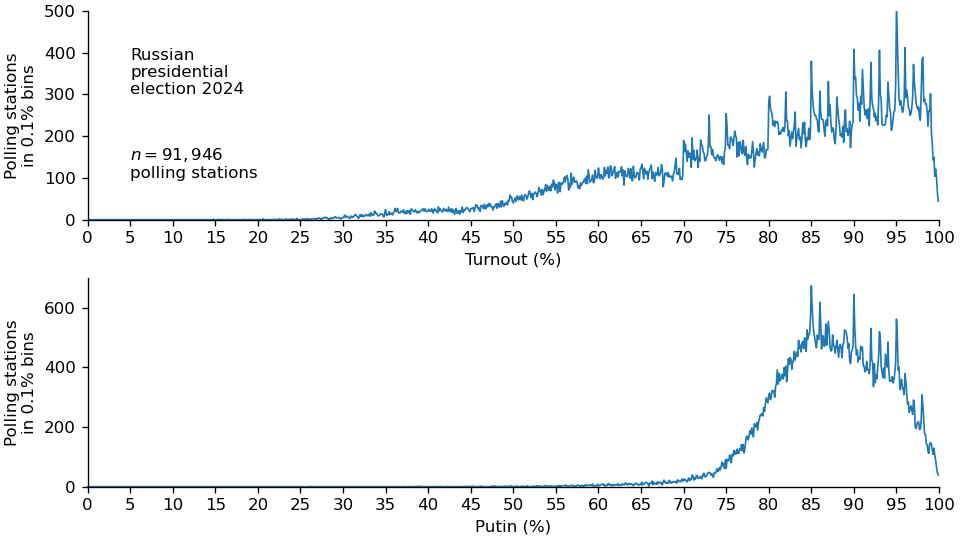

In [5]:
binwidth = 0.1         # Bin width (in percentage points)
addNoise = True        # If add U(-0.5,0.5) noise to the nominators (to remove division artifacts)
weights  = 'off'       # Weights: can be 'off'     (counts polling stations), 
                       #                 'voters'  (counts registered voters),
                       #                 'given'   (counts given ballots)
                       #                 'leader'  (counts ballots for the leader)
minSize  = 0           # Exclude polling stations with number of voters less than minSize

# Settings used in our papers:
# * AOAS-2016:         binwidth=0.1,  addNoise=False, weights='voters', minSize = 0
# * Significance-2016: binwidth=0.25, addNoise=True,  weights='off'     minSize = 0
# * Significance-2018: binwidth=0.1,  addNoise=True,  weights='off'     minSize = 0

######################################################################################

ind = ~np.isnan(received) & (received > 0) & (given < voters) & (voters >= minSize)
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

np.random.seed(42)
noise = np.zeros(np.sum(ind)) if not addNoise else np.random.rand(np.sum(ind)) - .5

w = None
if weights == 'voters': w = voters[ind]
if weights == 'given':  w = given[ind]
if weights == 'leader': w = leader[ind]
h1 = np.histogram(100 * (given[ind]+noise)/voters[ind],    bins=edges, weights = w)[0]
h2 = np.histogram(100 * (leader[ind]+noise)/received[ind], bins=edges, weights = w)[0]

ylbl = 'Polling stations'
if weights == 'voters': ylbl = 'Voters'
if weights == 'given':  ylbl = 'Ballots given'
if weights == 'leader': ylbl = 'Ballots for leader'


plt.figure(figsize=(8,4.5), layout='constrained')
plt.subplot(211)
plt.plot(centers, h1, linewidth=1)
plt.xlabel("Turnout (%)")
plt.ylabel('{}\nin {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,5))
plt.xlim([0,100])
plt.ylim([0, 500])
plt.gca().spines[['right', 'top']].set_visible(False)

plt.text(5, 300, 'Russian\npresidential\nelection 2024')
plt.text(5, 100, f'$n={np.size(leader):,}$\npolling stations')

plt.subplot(212)
plt.plot(centers, h2, linewidth=1, clip_on=False)
plt.xlabel("Putin (%)")
plt.ylabel('{}\nin {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,5))
plt.xlim([0,100])
plt.ylim([0, 700])
plt.gca().spines[['right', 'top']].set_visible(False)

plt.savefig('peaks.png', dpi=200)

## Integer anomalies

In [6]:
# Monte Carlo simulations

import time

def anomaly(voters, given, received, leader, nrep=1000, prctl = 99.9, seed=42, 
            binwidth = .1, period = 1):
    
    # inclusion criteria that we used in the AOAS paper
    ind = (received > 0) & (voters >= 100)
    indd = (given[ind]/voters[ind] <= .99) & (leader[ind]/received[ind] <= .99)
    ind[np.where(ind)[0][~indd]] = False    
    
    p1 = 100 * leader[ind]/received[ind]
    p2 = 100 * given[ind]/voters[ind]
    
    # first dimension:  overall / only result / only turnout
    # second dimension: number of stations, voters, given ballots, leader's ballots
    integer = np.zeros((3,4)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer[0,i] = np.sum(w[(np.abs(p1 - np.round(p1/period)*period)  <= binwidth/2) | 
                                (np.abs(p2 - np.round(p2/period)*period)  <= binwidth/2)])
        integer[1,i] = np.sum(w[ np.abs(p1 - np.round(p1/period)*period)  <= binwidth/2])
        integer[2,i] = np.sum(w[ np.abs(p2 - np.round(p2/period)*period)  <= binwidth/2])

    t = time.time()    
    leader_binom = np.zeros((nrep, np.sum(ind)))
    given_binom  = np.zeros((nrep, np.sum(ind)))
    np.random.seed(seed)
    for n in range(np.sum(ind)):
        if n%1000 == 0:
            print('.', end='')
        leader_binom[:,n] = np.random.binomial(n=received[ind][n], 
                                               p=leader[ind][n]/received[ind][n], 
                                               size=nrep)
        given_binom[:,n]  = np.random.binomial(n=voters[ind][n],   
                                               p=given[ind][n] /voters[ind][n],   
                                               size=nrep)
    t = time.time() - t
    m,s = divmod(t, 60)
    print('{:2.0f}m {:2.0f}s'.format(m,s))
    
    p1 = 100 * leader_binom/received[ind]
    p2 = 100 * given_binom/voters[ind]    
    integer_mc = np.zeros((3,4,nrep)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer_mc[0,i,:] = np.sum(w * ((np.abs(p1 - np.round(p1/period)*period) <= binwidth/2) | 
                                        (np.abs(p2 - np.round(p2/period)*period) <= binwidth/2)), axis=1)
        integer_mc[1,i,:] = np.sum(w *  (np.abs(p1 - np.round(p1/period)*period) <= binwidth/2), axis=1)
        integer_mc[2,i,:] = np.sum(w *  (np.abs(p2 - np.round(p2/period)*period) <= binwidth/2), axis=1)  
        
    d = integer - np.mean(integer_mc, axis=2) 
    s = np.std(integer_mc, axis=2)
    q = np.percentile(integer_mc, prctl, axis=2) - np.mean(integer_mc, axis=2)
    return (d,s,q)  # anomaly, MC std, MC percentile

In [7]:
years = np.array([2024])

anomalies = np.zeros((years.size, 3, 4))
stds  = np.zeros((years.size, 3, 4))
prctls = np.zeros((years.size, 3, 4))

for i,y in enumerate(years):
    voters, given, received, leader, regions, oiks, tiks, uiks = loaddata(y, verbose=False)
    a = anomaly(voters, given, received, leader)
    anomalies[i,:,:] = a[0]
    stds[i,:,:]      = a[1]
    prctls[i,:,:]    = a[2]
    
with open('../duma2021/montecarlo.pickle', 'rb') as f:
    a, s, p, y = pickle.load(f)
    
anomalies = np.concatenate((a, anomalies))
stds = np.concatenate((s, stds))
prctls = np.concatenate((p, prctls))
years = np.concatenate((y, years))

with open('montecarlo.pickle', 'wb') as f:
    pickle.dump([anomalies, stds, prctls, years], f)

Excluded 2268 stations without data

...................................................................................... 1m 40s


[ 108.577   84.458  933.748  722.725 1722.779 1003.477 1159.585 1502.391
 1708.839 3610.885 1309.768 2930.984]


<IPython.core.display.Javascript object>


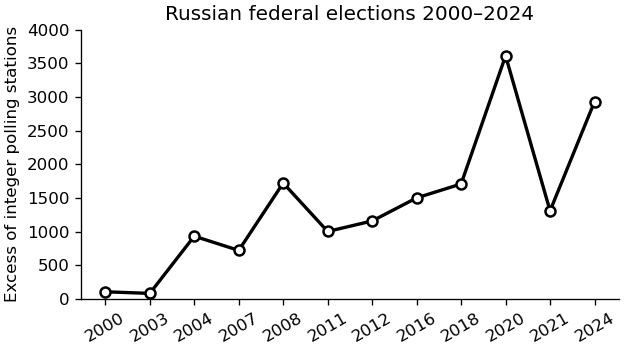

In [8]:
with open('montecarlo.pickle', 'rb') as f:
    anomalies, stds, prctls, years = pickle.load(f)
print(anomalies[:,0,0])

plt.figure(figsize=(8 * 0.65, 4.5 * 0.65), layout='constrained')
plt.plot(anomalies[:,0,0], '-ko', markerfacecolor='w', linewidth=2, markeredgewidth=1.5)
plt.ylabel('Excess of integer polling stations')
plt.title('Russian federal elections 2000–2024')
plt.ylim([0, 4000])
plt.xticks(np.arange(years.size), years, rotation=30)
plt.gca().spines[['right', 'top']].set_visible(False)

plt.savefig('integer-anomalies.png', dpi=200)